In [19]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [20]:
def ensure_minutely_index(df, time_col = None):
    df = df.copy()
    if time_col is not None:
        df[time_col] = pd.to_datetime(df[time_col])
        df = df.set_index(time_col)

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df index가 DatetimeIndex가 아님. time_col 지정 또는 index를 datetime으로 설정 필요.")

    df = df.sort_index()
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="min")
    return df.reindex(full_idx)

In [21]:
def fill_missing_timewise(df, method = "time"):
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].interpolate(method=method, limit_direction="both")
    df[num_cols] = df[num_cols].ffill().bfill()
    return df

In [22]:
def make_feature_window_dataset_minutely_multi(
    df_1min,
    target_cols,
    feature_cols,
    window_days = 30,
    horizon_minutes = 10,
    step = 10,
    target_mode = "mean",  # "point" | "mean60" | "sum60"
):
    df = df_1min.copy()

    for c in target_cols + feature_cols:
        if c not in df.columns:
            raise ValueError(f"필요 컬럼 누락: {c}")

    window_len = window_days * 24 * 60
    H = int(horizon_minutes)

    X_src = df[feature_cols].to_numpy(dtype=np.float64)
    Y_src = df[target_cols].to_numpy(dtype=np.float64)
    idx = df.index

    max_start = len(df) - window_len - H
    if max_start <= 0:
        raise ValueError("데이터가 윈도우(30일)+horizon(60분)보다 짧음.")

    # 특징: feature_cols 각각에 대해 mean/std/min/max/last
    feature_names = []
    for c in feature_cols:
        feature_names += [f"{c}__mean", f"{c}__std", f"{c}__min", f"{c}__max", f"{c}__last"]

    feats, ys, ts = [], [], []

    for start in range(0, max_start, step):
        end = start + window_len  # 현재 시점 t(윈도우 끝)

        w = X_src[start:end, :]  # (window_len, n_featcols)
        w_mean = np.nanmean(w, axis=0)
        w_std  = np.nanstd(w, axis=0)
        w_min  = np.nanmin(w, axis=0)
        w_max  = np.nanmax(w, axis=0)
        w_last = w[-1, :]

        x = np.concatenate([w_mean, w_std, w_min, w_max, w_last], axis=0)

        if target_mode == "point":
            y = Y_src[end + H, :]  # t+10의 각 타깃 값
            t_target = idx[end + H]
        elif target_mode == "mean":
            seg = Y_src[end+1:end+H+1, :]  # 다음 10분
            y = np.nanmean(seg, axis=0)
            t_target = idx[end + H]
        elif target_mode == "sum":
            seg = Y_src[end+1:end+H+1, :]
            y = np.nansum(seg, axis=0)
            t_target = idx[end + H]
        else:
            raise ValueError("target_mode는 'point'|'mean60'|'sum60' 중 하나여야 함.")

        feats.append(x)
        ys.append(y)
        ts.append(t_target)

    X = np.vstack(feats).astype(np.float32)
    Y = np.vstack(ys).astype(np.float32)  # (n_samples, n_targets)
    t_target = pd.DatetimeIndex(ts)

    return X, Y, t_target, feature_names

In [23]:
def evaluate_multi(y_true, y_pred, target_cols):
    metrics = {}
    eps = 1e-6
    for j, name in enumerate(target_cols):
        yt = y_true[:, j]
        yp = y_pred[:, j]
        mae = mean_absolute_error(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        mape = np.mean(np.abs((yt - yp) / np.maximum(np.abs(yt), eps))) * 100.0
        r2 = r2_score(yt, yp)
        metrics[name] = {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape, "R2": r2}
    return metrics

In [24]:
def train_predict_evaluate_minutely_multi(
    df_raw,
    time_col,
    target_cols,
    feature_cols = None,
    window_days = 30,
    horizon_minutes = 60,
    step = 60,
    target_mode = "mean60",
    test_ratio = 0.2,
    out_csv = "pred_tms_targets.csv",
):
    df_1min = ensure_minutely_index(df_raw, time_col=time_col)
    df_1min = fill_missing_timewise(df_1min)

    # feature_cols 미지정이면: 타깃 포함 전체 숫자컬럼 사용(= 과거 타깃 포함)
    if feature_cols is None:
        num_cols = df_1min.select_dtypes(include=[np.number]).columns.tolist()
        feature_cols = num_cols  # 타깃도 포함될 수 있음(과거값 사용)

    X, Y, t_target, feat_names = make_feature_window_dataset_minutely_multi(
        df_1min,
        target_cols=target_cols,
        feature_cols=feature_cols,
        window_days=window_days,
        horizon_minutes=horizon_minutes,
        step=step,
        target_mode=target_mode
    )

    n = len(t_target)
    n_test = int(np.floor(n * test_ratio))
    n_train = n - n_test
    if n_train <= 0 or n_test <= 0:
        raise ValueError("train/test 분할 실패. 데이터 길이 또는 test_ratio 확인.")

    X_train, Y_train = X[:n_train], Y[:n_train]
    X_test,  Y_test  = X[n_train:], Y[n_train:]
    t_test = t_target[n_train:]

    model = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lr", LinearRegression())  # 멀티아웃풋 자동 지원
    ])
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test).astype(np.float32)

    metrics = evaluate_multi(Y_test, Y_pred, target_cols)

    # 저장: wide 포맷 (y_true_*, y_pred_*)
    out = pd.DataFrame(index=t_test)
    for j, name in enumerate(target_cols):
        out[f"y_true__{name}"] = Y_test[:, j]
        out[f"y_pred__{name}"] = Y_pred[:, j]
    out.to_csv(out_csv, encoding="utf-8-sig")

    return df_1min, out, metrics, feat_names, model

In [25]:
def plot_one_target(out, target, title = None):
    yt = out[f"y_true__{target}"]
    yp = out[f"y_pred__{target}"]

    plt.figure()
    plt.plot(out.index, yt, label="true")
    plt.plot(out.index, yp, label="pred")
    plt.title(title or f"{target}: True vs Pred")
    plt.xlabel("time")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
target_cols = ["TOC_VU","PH_VU","SS_VU","FLUX_VU","TN_VU","TP_VU"]
df_raw = pd.read_csv("../../data/processed/tms_processed.csv")
df_1min, out, metrics, feat_names, model = train_predict_evaluate_minutely_multi(
    df_raw,
    time_col="SYS_TIME",
    target_cols=target_cols,
    feature_cols=None,         # None이면 숫자컬럼 전부 사용(타깃 과거 포함)
    window_days=30,
    horizon_minutes=10,
    step=10,
    target_mode="mean",
    test_ratio=0.2,
    out_csv="pred_tms_targets.csv"
)

# 타깃별 성능 확인
print(metrics["TOC_VU"])
# 시각화(하나씩)


In [31]:
print(f"R2: {metrics["TOC_VU"]["R2"]} \nRMSE: {metrics["TOC_VU"]["RMSE"]} \nMAE: {metrics["TOC_VU"]["MAE"]} \nMAPE(%): {metrics["TOC_VU"]["MAPE(%)"]}")
print(f"R2: {metrics["PH_VU"]["R2"]} \nRMSE: {metrics["PH_VU"]["RMSE"]} \nMAE: {metrics["PH_VU"]["MAE"]} \nMAPE(%): {metrics["PH_VU"]["MAPE(%)"]}")
print(f"R2: {metrics["SS_VU"]["R2"]} \nRMSE: {metrics["SS_VU"]["RMSE"]} \nMAE: {metrics["SS_VU"]["MAE"]} \nMAPE(%): {metrics["SS_VU"]["MAPE(%)"]}")
print(f"R2: {metrics["FLUX_VU"]["R2"]} \nRMSE: {metrics["FLUX_VU"]["RMSE"]} \nMAE: {metrics["FLUX_VU"]["MAE"]} \nMAPE(%): {metrics["FLUX_VU"]["MAPE(%)"]}")
print(f"R2: {metrics["TN_VU"]["R2"]} \nRMSE: {metrics["TN_VU"]["RMSE"]} \nMAE: {metrics["TN_VU"]["MAE"]} \nMAPE(%): {metrics["TN_VU"]["MAPE(%)"]}")
print(f"R2: {metrics["TP_VU"]["R2"]} \nRMSE: {metrics["TP_VU"]["RMSE"]} \nMAE: {metrics["TP_VU"]["MAE"]} \nMAPE(%): {metrics["TP_VU"]["MAPE(%)"]}")


R2: -4.596914768218994 
RMSE: 7.397290182125764 
MAE: 6.130698204040527 
MAPE(%): 2567921.5
R2: -18.15496253967285 
RMSE: 0.6590679384805752 
MAE: 0.10965807735919952 
MAPE(%): 21978.6796875
R2: -5.308851718902588 
RMSE: 2.6265916086339236 
MAE: 0.9070245623588562 
MAPE(%): 399477.40625
R2: 0.9873223900794983 
RMSE: 45201.33520151811 
MAE: 1516.1761474609375 
MAPE(%): 11.972585678100586
R2: -3.3522963523864746 
RMSE: 4.784890777074766 
MAE: 0.8995549082756042 
MAPE(%): 7082133.0
R2: -78.27156066894531 
RMSE: 0.22165860483351152 
MAE: 0.1849478781223297 
MAPE(%): 7445272.5


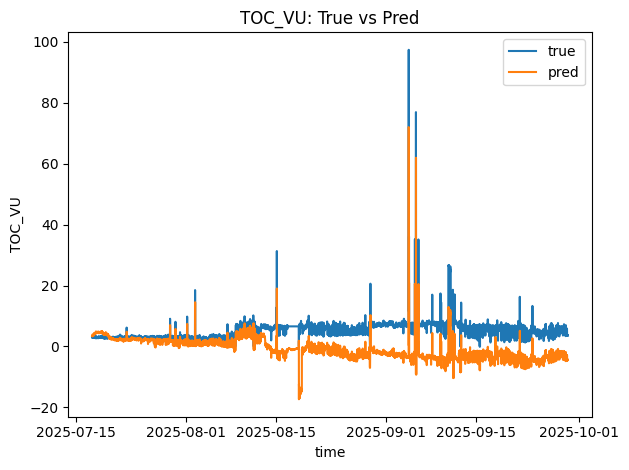

In [37]:
plot_one_target(out, "TOC_VU")

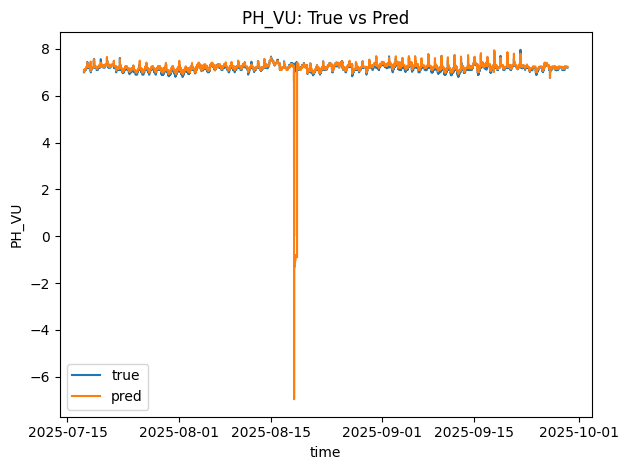

In [32]:
plot_one_target(out, "PH_VU")

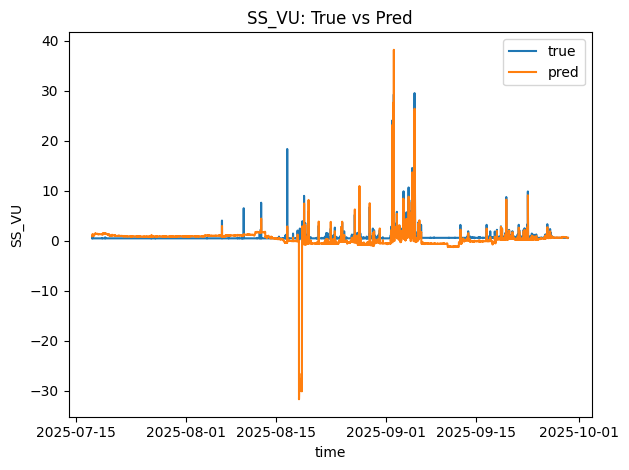

In [33]:
plot_one_target(out, "SS_VU")

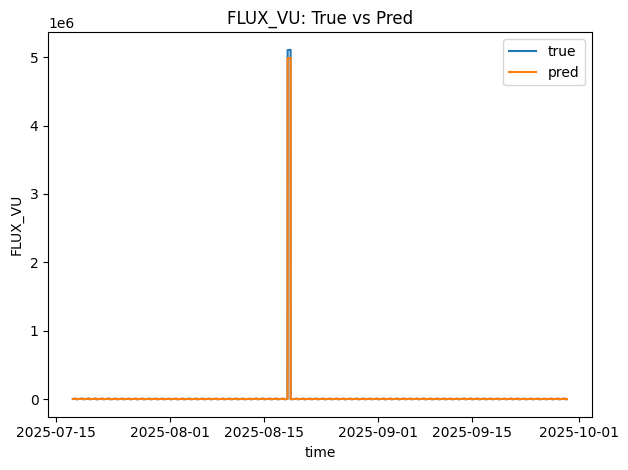

In [34]:
plot_one_target(out, "FLUX_VU")

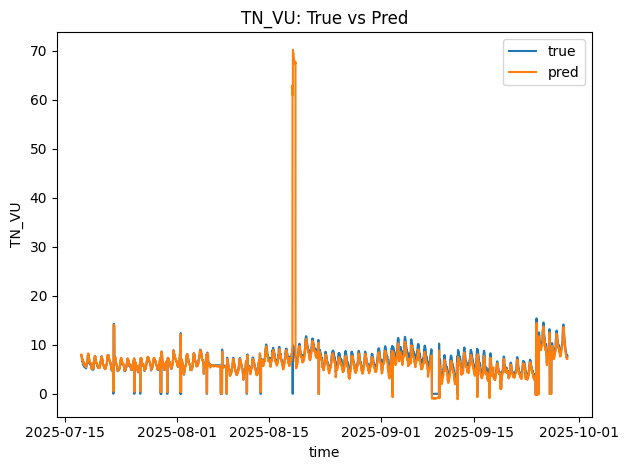

In [35]:
plot_one_target(out, "TN_VU")

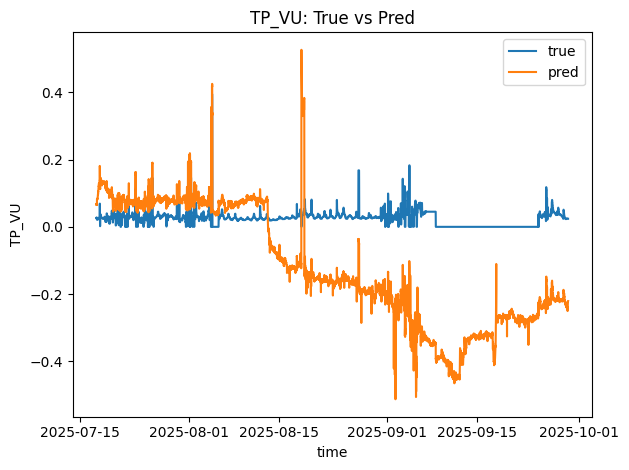

In [36]:
plot_one_target(out, "TP_VU")